# Rocket League Challenge

The dataset consists of sequences of snapshots of the state of a Rocket League match, including position and velocity of all players and the ball, as well as extra information.

**Goal of the competition**: The goal of the competition is to predict -- from a given snapshot in the game -- for each team, the probability that they will score within the next 10 seconds of game time.

The data was taken from professional Rocket League matches. Each event consists of a chronological series of frames recorded at 10 frames per second. All events begin with a kickoff, and most end in one team scoring a goal, but some are truncated and end with no goal scored due to circumstances which can cause gameplay strategies to shift, for example 1) nearing end of regulation (where the game continues until the ball touches the ground) or 2) becoming non-competitive, eg one team winning by 3+ goals with little time remaining.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch_lightning
!pip install icecream
!pip install pprinter
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 4.5 MB/s 
     |████████████████████████████████| 512 kB 83.8 MB/s 
     |████████████████████████████████| 125 kB 99.0 MB/s 
     |████████████████████████████████| 87 kB 8.7 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=4df258307f4fe6402f66e529349ab48d76770f0add444a4c39f6ef5f426fdafa
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pprinter: filename=pprinter-0.0.1-py3-none-any.whl size=2233 sha256=4813c59679871cbba38570477273dbde757105117bbc87bd8d9cd216695b73e9
  Stored in directory: /root/.cache/pip

In [ ]:
from icecream import ic
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [ ]:
# reduce mem usage
# thanks to : ?.ipynb  for this function
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Creating Datasets

In [ ]:


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

files_name = []
import os
for dirname, _, filenames in os.walk('//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        files_name.append(os.path.join(dirname, filename))




//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/test_dtypes.csv
//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/sample_submission.csv
//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/test.csv
//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/train_0.csv
//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/train_1.csv
//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/train_2.csv
//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/train_3.csv
//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/train_4.csv
//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-pl

We shuffle the dataset and try to train a model as if the rows were independent. 
**we could also have used the timeseries information with recurrent network, but we won't for now.**

In [ ]:
# reading train dataset
# we will not use all the dataset but just a sample of each train dataset: 
import gc 
SAMPLE=0.2
import pandas as pd
# import tqdm
path_to_data = os.path.dirname(files_name[0])
print(path_to_data)

dtypes_df = pd.read_csv('//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/train_dtypes.csv')
dtypes = {k: v for (k, v) in zip(dtypes_df.column, dtypes_df.dtype)}

cols = list(dtypes.keys())
train_df = pd.DataFrame({}, columns=cols)
for i in range(10):
    print(i)
    df_tmp = pd.read_csv(f'{path_to_data}/train_{i}.csv', dtype=dtypes)
    if SAMPLE < 1:
        df_tmp = df_tmp.sample(frac=SAMPLE, random_state=42)

    train_df = pd.concat([train_df,df_tmp])

    del df_tmp
    gc.collect()

  # train +   = pd.read_csv(i, dtype=dtypes)

//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022
0
1
2
3
4
5
6
7
8
9


In [ ]:
import numpy as np
wha

In [ ]:
train_df

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
440953,151,151001,-60.468750,-60.750000,54.531250,2.773438,18.265625,-21.093750,0.999023,79.500000,...,-1.795898,0.000000,-4.492188,0.000000,-1.725586,-9.320312,4,B,0,0
176360,63,63003,-39.406250,51.718750,68.125000,31.546875,-17.609375,-5.867188,-14.742188,69.437500,...,0.000000,0.000000,-1.041992,-2.859375,-5.054688,-7.140625,3,B,0,0
282629,99,99001,-92.500000,-7.183594,-85.125000,22.562500,16.828125,-20.140625,-10.640625,-46.343750,...,-1.191406,0.000000,-3.861328,0.000000,-0.122742,0.000000,3,B,0,0
1765627,607,607001,-55.687500,-71.312500,-3.058594,9.921875,36.281250,5.714844,14.851562,-53.468750,...,0.000000,-8.343750,-9.500000,0.000000,0.000000,-4.355469,1,A,0,0
1274297,434,434002,-4.304688,79.937500,29.296875,16.781250,-0.189209,-1.642578,8.906250,62.343750,...,-4.171875,0.000000,0.000000,-9.000000,0.000000,-9.140625,2,A,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930896,7306,7306003,-52.875000,46.250000,29.312500,35.906250,13.710938,-29.015625,-4.800781,-24.953125,...,0.000000,0.000000,-0.389648,0.000000,0.000000,-1.291016,3,B,0,0
1393704,7118,7118001,-52.875000,-26.859375,75.562500,8.742188,7.039062,18.015625,-2.439453,-38.875000,...,-4.164062,0.000000,0.000000,0.000000,-7.097656,0.000000,4,B,0,0
274074,6725,6725003,-113.562500,37.000000,26.218750,4.484375,31.312500,2.765625,-33.437500,16.296875,...,0.000000,-9.781250,-3.160156,-0.279785,-7.406250,0.000000,3,B,0,0
824495,6917,6917005,-143.625000,18.781250,70.500000,22.906250,28.109375,-23.093750,-4.375000,80.687500,...,-3.740234,-0.733398,-2.203125,-3.181641,-0.628418,-8.953125,-1,NaN,0,0


# Data exploration

In [ ]:
#Reduce memory utilisation



In [ ]:
# reading test dataset
dtypes_df = pd.read_csv('//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/test_dtypes.csv')
dtypes = {k: v for (k, v) in zip(dtypes_df.column, dtypes_df.dtype)}
test = pd.read_csv('//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/test.csv', dtype=dtypes)

In [ ]:
test.head()

,id,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,p0_pos_y,p0_pos_z,...,p5_vel_x,p5_vel_y,p5_vel_z,p5_boost,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer
0,0,-56.270802,29.510000,17.348600,24.499399,-1.311400,11.006801,-35.776199,73.136803,1.2480,...,3.948400,-16.710800,0.0074,71.0000,0.000000,-3.263672,-6.132812,-6.875000,-7.015625,-3.230469
1,1,2.852800,70.195999,8.949000,-8.152200,-65.577202,18.536400,22.926001,87.543800,0.3396,...,-15.496800,-14.876600,0.0050,66.6875,0.000000,-1.615234,-5.968750,-5.503906,0.000000,-6.511719
2,2,52.366402,-98.036797,14.249001,-2.000000,-45.291401,-15.423400,51.288998,-102.055595,6.3570,...,0.905800,-27.413601,0.0042,80.3750,-0.031586,0.000000,0.000000,-3.128906,0.000000,-3.677734
3,3,36.365402,53.961403,23.161798,24.829399,-10.328600,-0.918000,16.424799,0.932800,0.3402,...,-5.053200,-15.106999,0.0052,96.0625,-6.429688,-4.089844,-7.832031,-5.761719,0.000000,-3.923828
4,4,-23.262400,-53.391003,21.209600,-1.667600,-24.778799,3.481200,-19.681801,-93.913605,4.7832,...,22.200001,24.928001,0.0042,0.0000,-9.882812,0.000000,-0.445557,-0.491455,-7.828125,0.000000


In [ ]:
print('Train data shape:', train_df.shape)
print('Test data shape:', test.shape)

Train data shape: (4239608, 61)
Test data shape: (701143, 55)


In [ ]:
missing_values_train = train_df.isna().sum().sum()
print('Missing values in train data: {0}'.format(missing_values_train[missing_values_train > 0]))

missing_values_test = test.isna().sum().sum()
print('Missing values in test data: {0}'.format(missing_values_test[missing_values_test > 0]))

Missing values in train data: [2569435]
Missing values in test data: [261422]


In [ ]:
# handle missing values for now : 
train0_df = train_df.dropna()
test = test.fillna(value=test.mean())

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [ ]:
missing_values_train = train0_df.isna().sum().sum()
print('Missing values in train data: {0}'.format(missing_values_train[missing_values_train > 0]))

missing_values_test = test.isna().sum().sum()
print('Missing values in test data: {0}'.format(missing_values_test[missing_values_test > 0]))

Missing values in train data: []
Missing values in test data: [37346]


In [ ]:
input_cols = [
    'ball_pos_x', 'ball_pos_y', 'ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 
    'p0_pos_x', 'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 
    'p1_pos_x', 'p1_pos_y', 'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z',
    'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y', 'p2_vel_z',
    'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x', 'p3_vel_y', 'p3_vel_z',
    'p4_pos_x', 'p4_pos_y', 'p4_pos_z', 'p4_vel_x', 'p4_vel_y', 'p4_vel_z',
    'p5_pos_x', 'p5_pos_y', 'p5_pos_z', 'p5_vel_x', 'p5_vel_y', 'p5_vel_z',
    'p0_boost', 'p1_boost',  'p2_boost', 'p3_boost', 'p4_boost', 'p5_boost',
    'boost0_timer', 'boost1_timer', 'boost2_timer', 'boost3_timer', 'boost4_timer', 'boost5_timer'
]

In [ ]:
output_cols = ['team_A_scoring_within_10sec', 'team_B_scoring_within_10sec']

In [ ]:
def int_to_grid_coord(k, n):
    return (k // n) + 1, (k % n) + 1

:Exploration is not possible on all data because of ram issues so we will get random samples of these data *

In [ ]:
SAMPLE_EXPLO=0.0001
explo_df = train_df.sample(frac=SAMPLE_EXPLO)

In [ ]:
explo_df.size

25864

In [ ]:
## visualisation

import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

def plot_distributions(df, row_count, col_count, title, height):
    features = df.columns
    fig = subplots.make_subplots(
        rows=row_count, cols=col_count,
        subplot_titles=features
    )

    for k, col in enumerate(features):
        i, j = int_to_grid_coord(k, col_count)

        fig.add_trace(
            go.Histogram(
                x=df[col].astype('float32'),
                name=col
            ),
            row=i, col=j
        )

    fig.update_layout(
        title=title,
        height=row_count * height,
        showlegend=False
    )

    return fig

plot_distributions(explo_df[input_cols],9,6,"first visualisation of inputs",300)

# Feature Reduction

In [ ]:
train = train_df.copy(deep=True)  # for easier exploration & for having a dataset checkpoint

train.keys()

Index(['game_num', 'event_id', 'event_time', 'ball_pos_x', 'ball_pos_y',
       'ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 'p0_pos_x',
       'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 'p0_boost',
       'p1_pos_x', 'p1_pos_y', 'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z',
       'p1_boost', 'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y',
       'p2_vel_z', 'p2_boost', 'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x',
       'p3_vel_y', 'p3_vel_z', 'p3_boost', 'p4_pos_x', 'p4_pos_y', 'p4_pos_z',
       'p4_vel_x', 'p4_vel_y', 'p4_vel_z', 'p4_boost', 'p5_pos_x', 'p5_pos_y',
       'p5_pos_z', 'p5_vel_x', 'p5_vel_y', 'p5_vel_z', 'p5_boost',
       'boost0_timer', 'boost1_timer', 'boost2_timer', 'boost3_timer',
       'boost4_timer', 'boost5_timer', 'player_scoring_next',
       'team_scoring_next', 'team_A_scoring_within_10sec',
       'team_B_scoring_within_10sec'],
      dtype='object')

### **Let's define some new features :**

- distance from the ball 
- absolute speed of the ball 
- minimum distance from a player to the goal 
- elevated before a goal or not ? 
- velocity magnitude of the players

#### Absolute speed of the ball

In [ ]:
# absolute speed of the ball :

array1 = train['ball_vel_x'].values*train['ball_vel_x'].values + train['ball_vel_y'].values*train['ball_vel_y'].values + train['ball_vel_z'].values*train['ball_vel_z'].values
array2 = test['ball_vel_x'].values*test['ball_vel_x'].values + test['ball_vel_y'].values*test['ball_vel_y'].values + test['ball_vel_z'].values*test['ball_vel_z'].values

train["abs_ball_speed"]=[np.sqrt(i) for i in array1]
test["abs_ball_speed"] = [np.sqrt(i) for i in array2]
train.keys()


Index(['game_num', 'event_id', 'event_time', 'ball_pos_x', 'ball_pos_y',
       'ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 'p0_pos_x',
       'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 'p0_boost',
       'p1_pos_x', 'p1_pos_y', 'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z',
       'p1_boost', 'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y',
       'p2_vel_z', 'p2_boost', 'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x',
       'p3_vel_y', 'p3_vel_z', 'p3_boost', 'p4_pos_x', 'p4_pos_y', 'p4_pos_z',
       'p4_vel_x', 'p4_vel_y', 'p4_vel_z', 'p4_boost', 'p5_pos_x', 'p5_pos_y',
       'p5_pos_z', 'p5_vel_x', 'p5_vel_y', 'p5_vel_z', 'p5_boost',
       'boost0_timer', 'boost1_timer', 'boost2_timer', 'boost3_timer',
       'boost4_timer', 'boost5_timer', 'player_scoring_next',
       'team_scoring_next', 'team_A_scoring_within_10sec',
       'team_B_scoring_within_10sec', 'abs_ball_speed'],
      dtype='object')

In [ ]:

#checking data for a given player
scorer_key = []
for i in train.keys():
  if "p3" in i:
    scorer_key.append(i)
print(scorer_key)

train[scorer_key]


['p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x', 'p3_vel_y', 'p3_vel_z', 'p3_boost']


,p3_pos_x,p3_pos_y,p3_pos_z,p3_vel_x,p3_vel_y,p3_vel_z,p3_boost
440953,5.089844,88.687500,0.340088,10.843750,-18.750000,0.005001,73.312500
176360,37.031250,77.125000,20.609375,12.437500,-17.906250,11.750000,65.250000
282629,-25.046875,-3.820312,0.340088,1.238281,-20.390625,0.005199,79.625000
1765627,61.468750,-15.578125,0.339844,-17.156250,41.375000,0.009598,89.000000
1274297,81.562500,71.875000,12.093750,-0.067810,-2.470703,33.437500,89.500000
...,...,...,...,...,...,...,...
1930896,37.687500,88.687500,0.340332,-4.386719,-20.265625,0.003000,33.718750
1393704,11.835938,98.625000,0.340088,-23.421875,7.429688,0.005199,87.812500
274074,20.109375,60.562500,0.340820,45.812500,4.070312,0.007401,87.812500
824495,8.250000,82.875000,18.625000,21.750000,-19.937500,-0.479736,16.421875


In [ ]:
# grouping by player and ball cat : 

vel_groups = {
    f"{el}_vel": [f'{el}_vel_x', f'{el}_vel_y', f'{el}_vel_z']
    for el in ['ball'] + [f'p{i}' for i in range(6)]
}
pos_groups = {
    f"{el}_pos": [f'{el}_pos_x', f'{el}_pos_y', f'{el}_pos_z']
    for el in ['ball'] + [f'p{i}' for i in range(6)]
}
pos_groups


{'ball_pos': ['ball_pos_x', 'ball_pos_y', 'ball_pos_z'],
 'p0_pos': ['p0_pos_x', 'p0_pos_y', 'p0_pos_z'],
 'p1_pos': ['p1_pos_x', 'p1_pos_y', 'p1_pos_z'],
 'p2_pos': ['p2_pos_x', 'p2_pos_y', 'p2_pos_z'],
 'p3_pos': ['p3_pos_x', 'p3_pos_y', 'p3_pos_z'],
 'p4_pos': ['p4_pos_x', 'p4_pos_y', 'p4_pos_z'],
 'p5_pos': ['p5_pos_x', 'p5_pos_y', 'p5_pos_z']}

#### Distance from the ball

In [ ]:
#distance from the ball: 
def euclidian_dist(x):
    return np.linalg.norm(x, axis=1)

# euclidian_dist(train[pos_groups["p0_pos"]].values - train[pos_groups["ball_pos"]].values)
# # train['p0_pos_x']
# # print(euclidian_dist(train['ball_pos_x'].values-train['p0_pos_x'].values))

for col, vec in pos_groups.items():
  print(vec)
  train[col + '_dist_ball'] = euclidian_dist(train[vec].values - train[pos_groups["ball_pos"]].values)
  test[col + '_dist_ball'] = euclidian_dist(test[vec].values - test[pos_groups["ball_pos"]].values)
  





['ball_pos_x', 'ball_pos_y', 'ball_pos_z']
['p0_pos_x', 'p0_pos_y', 'p0_pos_z']
['p1_pos_x', 'p1_pos_y', 'p1_pos_z']
['p2_pos_x', 'p2_pos_y', 'p2_pos_z']
['p3_pos_x', 'p3_pos_y', 'p3_pos_z']
['p4_pos_x', 'p4_pos_y', 'p4_pos_z']
['p5_pos_x', 'p5_pos_y', 'p5_pos_z']


In [ ]:
game_1 = train[train["game_num"]==1]


# check at what distance from the ball was the player that scores before shooting. 
min((x) for x in game_1['p3_pos_dist_ball'])

3.69140625

#### Velocity Magnitude

In [ ]:

# velocity magnitude
for col, vec in vel_groups.items():
    train[col] = euclidian_dist(train[vec])
    test[col] = euclidian_dist(test[vec])


#### Closer player to the ball

In [ ]:
train.keys()

Index(['game_num', 'event_id', 'event_time', 'ball_pos_x', 'ball_pos_y',
       'ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 'p0_pos_x',
       'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 'p0_boost',
       'p1_pos_x', 'p1_pos_y', 'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z',
       'p1_boost', 'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y',
       'p2_vel_z', 'p2_boost', 'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x',
       'p3_vel_y', 'p3_vel_z', 'p3_boost', 'p4_pos_x', 'p4_pos_y', 'p4_pos_z',
       'p4_vel_x', 'p4_vel_y', 'p4_vel_z', 'p4_boost', 'p5_pos_x', 'p5_pos_y',
       'p5_pos_z', 'p5_vel_x', 'p5_vel_y', 'p5_vel_z', 'p5_boost',
       'boost0_timer', 'boost1_timer', 'boost2_timer', 'boost3_timer',
       'boost4_timer', 'boost5_timer', 'player_scoring_next',
       'team_scoring_next', 'team_A_scoring_within_10sec',
       'team_B_scoring_within_10sec', 'abs_ball_speed', 'ball_pos_dist_ball',
       'p0_pos_dist_ball', 'p1_pos_dist_b

In [ ]:
# dist_cols=['p0_pos_dist_ball',
#        'p1_pos_dist_ball', 'p2_pos_dist_ball', 'p3_pos_dist_ball',
#        'p4_pos_dist_ball', 'p5_pos_dist_ball']


# dict = {'p0_pos_dist_ball':0,
#        'p1_pos_dist_ball':1,
#         'p2_pos_dist_ball':2,
#         'p3_pos_dist_ball':3,
#        'p4_pos_dist_ball':4,
#         'p5_pos_dist_ball':5}

# df2 = df.replace(['Spark','PySpark'],['Apache Spark', 'Apache PySpark'])
# print(df)





# train.replace(['p0_pos_dist_ball',
#        'p1_pos_dist_ball', 'p2_pos_dist_ball', 'p3_pos_dist_ball',
#        'p4_pos_dist_ball', 'p5_pos_dist_ball'],[0,1,2,3,4,5],inplace=True)

# test.replace(['p0_pos_dist_ball',
#        'p1_pos_dist_ball', 'p2_pos_dist_ball', 'p3_pos_dist_ball',
#        'p4_pos_dist_ball', 'p5_pos_dist_ball'],[0,1,2,3,4,5],inplace=True)

# print(train['closest_p_to_ball'])
# print(test)

In [ ]:
dist_cols=['p0_pos_dist_ball',
       'p1_pos_dist_ball', 'p2_pos_dist_ball', 'p3_pos_dist_ball',
       'p4_pos_dist_ball', 'p5_pos_dist_ball']


train['closest_p_to_ball']=train[dist_cols].idxmin(axis=1)
test['closest_p_to_ball']=test[dist_cols].idxmin(axis=1)

train.replace(['p0_pos_dist_ball',
       'p1_pos_dist_ball', 'p2_pos_dist_ball', 'p3_pos_dist_ball',
       'p4_pos_dist_ball', 'p5_pos_dist_ball'],[0,1,2,3,4,5],inplace=True)

test.replace(['p0_pos_dist_ball',
       'p1_pos_dist_ball', 'p2_pos_dist_ball', 'p3_pos_dist_ball',
       'p4_pos_dist_ball', 'p5_pos_dist_ball'],[0,1,2,3,4,5],inplace=True)

print(train['closest_p_to_ball'])


440953     4
176360     3
282629     4
1765627    4
1274297    1
          ..
1930896    1
1393704    4
274074     0
824495     3
1129841    5
Name: closest_p_to_ball, Length: 4239608, dtype: int64


#### Minimum distance from the goal


In [ ]:
# was there a goal in cage ? 
# minimum distance from the goal
# we are going to assume that there was no goal if the closest palyer from the ball is the one who ends up scoring. 
#Is there a 'goal keeper', i.e. a player defending in goal, or is it an open goal? The right feature for this would be the minimum distance of a player to the goal.

#lets compute minimum distance from the ball at time 


# pas encore fait



In [ ]:
# who is the closest to the ball ? 


#### Recule ou avance au moment du but


#### Elevation of the scoring player

In [ ]:
# to do 


#### Angle et Formation des équipes ? 


In [ ]:
# Distance entre les joueurs d'une même équipe


# Condition sur les buts d'une équipe 

# angle et (formation/position des players/ x,y,z de chaque joueur) au moment du but ?


# maximum position players pour définir le terrain



**Idée de features**
- 


# Feature Reduction 

We might want to use algorithms for feature reductions ? 

In [ ]:
# # Standarise the Data
# X_org = image_matrix.copy()
# sc = StandardScaler()
# X = sc.fit_transform(X_org)
# # this is the size of our encoded representations
# encoding_dim = reduced_pixel 
# # this is our input placeholder
# input_img = Input(shape=(img.width,))
# # "encoded" is the encoded representation of the input
# encoded = Dense(encoding_dim, activation='linear')(input_img)
# # "decoded" is the lossy reconstruction of the input
# decoded = Dense(img.width, activation=None)(encoded)
# # this model maps an input to its reconstruction
# autoencoder = Model(input_img, decoded)
# #Encoder
# encoder = Model(input_img, encoded)
# # create a placeholder for an encoded (32-dimensional) input
# encoded_input = Input(shape=(encoding_dim,))
# # retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-1]
# # create the decoder model
# decoder = Model(encoded_input, decoder_layer(encoded_input))
# autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
# autoencoder.fit(X, X,
#                 epochs=500,
#                 batch_size=16,
#                 shuffle=True)
# encoded_imgs = encoder.predict(X)
# decoded_imgs = decoder.predict(encoded_imgs)

#  data cleaning

In [ ]:
train.keys()
test.keys()

Index(['id', 'ball_pos_x', 'ball_pos_y', 'ball_pos_z', 'ball_vel_x',
       'ball_vel_y', 'ball_vel_z', 'p0_pos_x', 'p0_pos_y', 'p0_pos_z',
       'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 'p0_boost', 'p1_pos_x', 'p1_pos_y',
       'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z', 'p1_boost', 'p2_pos_x',
       'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y', 'p2_vel_z', 'p2_boost',
       'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x', 'p3_vel_y', 'p3_vel_z',
       'p3_boost', 'p4_pos_x', 'p4_pos_y', 'p4_pos_z', 'p4_vel_x', 'p4_vel_y',
       'p4_vel_z', 'p4_boost', 'p5_pos_x', 'p5_pos_y', 'p5_pos_z', 'p5_vel_x',
       'p5_vel_y', 'p5_vel_z', 'p5_boost', 'boost0_timer', 'boost1_timer',
       'boost2_timer', 'boost3_timer', 'boost4_timer', 'boost5_timer',
       'abs_ball_speed', 'ball_pos_dist_ball', 'p0_pos_dist_ball',
       'p1_pos_dist_ball', 'p2_pos_dist_ball', 'p3_pos_dist_ball',
       'p4_pos_dist_ball', 'p5_pos_dist_ball', 'ball_vel', 'p0_vel', 'p1_vel',
       'p2_vel', 'p3_vel', 

In [ ]:
#Visualisation of new fe@atures : 
## visualisation
new_cols = ['abs_ball_speed', 'ball_pos_dist_ball',
       'p0_pos_dist_ball', 'p1_pos_dist_ball', 'p2_pos_dist_ball',
       'p3_pos_dist_ball', 'p4_pos_dist_ball', 'p5_pos_dist_ball', 'ball_vel',
       'p0_vel', 'p1_vel', 'p2_vel', 'p3_vel', 'p4_vel', 'p5_vel',"closest_p_to_ball"]


import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

def plot_distributions(df, row_count, col_count, title, height,frac = 0.00005):
    df = df.sample(frac = frac)
    features = df.columns
    fig = subplots.make_subplots(
        rows=row_count, cols=col_count,
        subplot_titles=features
    )

    for k, col in enumerate(features):
        i, j = int_to_grid_coord(k, col_count)

        fig.add_trace(
            go.Histogram(
                x=df[col].astype('float32'),
                name=col
            ),
            row=i, col=j
        )

    fig.update_layout(
        title=title,
        height=row_count * height,
        showlegend=False
    )

    return fig

plot_distributions(train[new_cols],6,3,"first visualisation of inputs",300)

We drop 'game_num', 'event_id', 'event_time" since they are not useful. 
we drop   'player_scoring_next', 'team_scoring_next''team_A_scoring_within_10sec',
                     'team_B_scoring_within_10sec' since they are data leakage/label
                     
FInally we also drop these features that we had compute since they are either not relevant or present twice in dataset "abs_ball_speed",'ball_pos_dist_ball


                   

In [ ]:
def preprocess_data(df):
  df = df.dropna().copy()

  return ({ 'A': df['team_A_scoring_within_10sec'], 'B': df['team_B_scoring_within_10sec'] },
            df.drop(['game_num', 'event_id', 'event_time',
                     'player_scoring_next', 'team_scoring_next',
                     'team_A_scoring_within_10sec',
                     'team_B_scoring_within_10sec',"abs_ball_speed",'ball_pos_dist_ball',], axis=1))


In [ ]:
test=test.drop(["id"],axis=1)
test = test.drop(["ball_pos_dist_ball","abs_ball_speed"],axis=1)

In [ ]:
test.keys()

Index(['ball_pos_x', 'ball_pos_y', 'ball_pos_z', 'ball_vel_x', 'ball_vel_y',
       'ball_vel_z', 'p0_pos_x', 'p0_pos_y', 'p0_pos_z', 'p0_vel_x',
       'p0_vel_y', 'p0_vel_z', 'p0_boost', 'p1_pos_x', 'p1_pos_y', 'p1_pos_z',
       'p1_vel_x', 'p1_vel_y', 'p1_vel_z', 'p1_boost', 'p2_pos_x', 'p2_pos_y',
       'p2_pos_z', 'p2_vel_x', 'p2_vel_y', 'p2_vel_z', 'p2_boost', 'p3_pos_x',
       'p3_pos_y', 'p3_pos_z', 'p3_vel_x', 'p3_vel_y', 'p3_vel_z', 'p3_boost',
       'p4_pos_x', 'p4_pos_y', 'p4_pos_z', 'p4_vel_x', 'p4_vel_y', 'p4_vel_z',
       'p4_boost', 'p5_pos_x', 'p5_pos_y', 'p5_pos_z', 'p5_vel_x', 'p5_vel_y',
       'p5_vel_z', 'p5_boost', 'boost0_timer', 'boost1_timer', 'boost2_timer',
       'boost3_timer', 'boost4_timer', 'boost5_timer', 'p0_pos_dist_ball',
       'p1_pos_dist_ball', 'p2_pos_dist_ball', 'p3_pos_dist_ball',
       'p4_pos_dist_ball', 'p5_pos_dist_ball', 'ball_vel', 'p0_vel', 'p1_vel',
       'p2_vel', 'p3_vel', 'p4_vel', 'p5_vel', 'closest_p_to_ball'],
      dtype

In [ ]:
# drop some colums : 
train_small = train.sample(frac=0.5) # for test purposes
y_train,X_train = preprocess_data(train)
y_train_small, X_train_small = preprocess_data(train_small)


##### train and test data

In [ ]:
from icecream import ic
ic(y_train["A"].shape)
ic(y_train['B'].shape)
ic(X_train.shape)


ic(y_train_small["A"].shape)
ic(y_train_small['B'].shape)
ic(X_train_small.shape)


ic(test.shape)

ic| y_train["A"].shape: (3108785,)
ic| y_train['B'].shape: (3108785,)
ic| X_train.shape: (3108785, 68)
ic| y_train_small["A"].shape: (1554881,)
ic| y_train_small['B'].shape: (1554881,)
ic| X_train_small.shape: (1554881, 68)
ic| test.shape: (701143, 68)


(701143, 68)

# Using XGBoost 


Since these are tabular data we think to XGboosting
The state of the art for problems with tabular data is currently ensembles of decision trees such as XGBDT or GBDT. 
At the moment, there are several established GBDT
libraries, such as XGBoost (Chen and Guestrin, 2016), LightGBM (Ke et al., 2017), CatBoost
(Prokhorenkova et al., 2018), which are widely used by both ML researchers and practitioners. While
these implementations vary in detail, on most of the tasks, their performances do not differ much.
We will first observe results with XGBoost. 




In [ ]:

import xgboost as xgb
from sklearn.model_selection import cross_validate  # k-fold Cross Validation
from sklearn.preprocessing import LabelEncoder 

*We'll be predicting the probability of team A scoring and team B scoring with 2 separate models.*
XGBoost n'est pas le meilleur avec du suréchantillonage. Il faudra surement réduire le nombre de donnnées pour éviter les éccueils. 



#### model A 


In [ ]:
# xgb.XGBClassifier??

In [ ]:
# training and cross validation

N_ESTIMATORS = 210
MAX_DEPTH = 8
LEARNING_RATE = 0.1
N_SPLITS = 5
my_seed = 42

param={}
param['booster'] = 'dart'
param['max_depth']=MAX_DEPTH
param["learning_rate"]=LEARNING_RATE
param["n_estimators"]=N_ESTIMATORS
param['objective']="binary"
param["tree_method"]='gpu_hist'
param["subsample"]=0.1
param["verbosity"]=0





scoring = 'neg_log_loss'
FOLDS = 5

In [ ]:
%matplotlib inline

In [ ]:
!pip install lightgbm
from lightgbm import LGBMClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Team: A 
5
/content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/models_saved/model_A_0.joblib


ic| val_y[:2]: 176360    0
               860935    0
               Name: team_A_scoring_within_10sec, dtype: category
               Categories (2, int64): [0, 1]
ic| predictions[:2]: array([0.02816709, 0.03150353])


predictions:[0.02816709 0.03150353 0.02362515 ... 0.1417222  0.08902794 0.03953074]
Fold 1 		 AUC: 0.7444851122814511


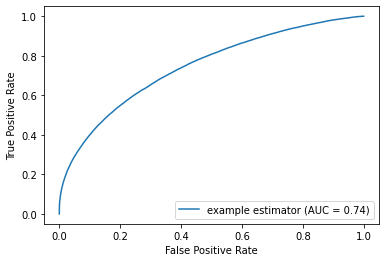

/content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/models_saved/model_A_1.joblib


ic| val_y[:2]: 440953     0
               1948527    0
               Name: team_A_scoring_within_10sec, dtype: category
               Categories (2, int64): [0, 1]
ic| predictions[:2]: array([0.05057811, 0.04914733])


predictions:[0.05057811 0.04914733 0.08596242 ... 0.07115798 0.03731661 0.05650697]
Fold 2 		 AUC: 0.7459784043952976


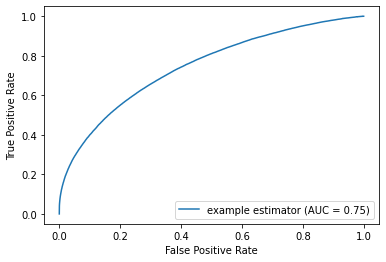

/content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/models_saved/model_A_2.joblib


ic| val_y[:2]: 282629     0
               1765627    0
               Name: team_A_scoring_within_10sec, dtype: category
               Categories (2, int64): [0, 1]
ic| predictions[:2]: array([0.01680435, 0.05100588])


predictions:[0.01680435 0.05100588 0.04676372 ... 0.06790328 0.03168984 0.09742087]
Fold 3 		 AUC: 0.7443003927491659


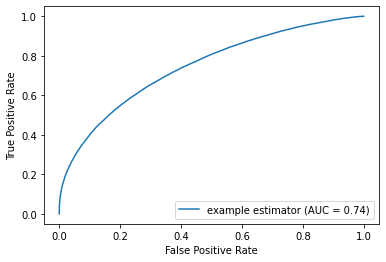

/content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/models_saved/model_A_3.joblib


ic| val_y[:2]: 1111514    0
               770636     0
               Name: team_A_scoring_within_10sec, dtype: category
               Categories (2, int64): [0, 1]
ic| predictions[:2]: array([0.06478298, 0.04413203])


predictions:[0.06478298 0.04413203 0.0936581  ... 0.06543189 0.01885949 0.01792695]
Fold 4 		 AUC: 0.746266973360254


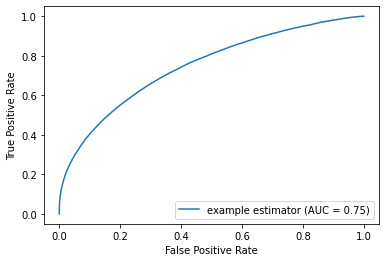

/content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/models_saved/model_A_4.joblib


ic| val_y[:2]: 1274297    1
               1177881    0
               Name: team_A_scoring_within_10sec, dtype: category
               Categories (2, int64): [0, 1]
ic| predictions[:2]: array([0.07012955, 0.0826565 ])


predictions:[0.07012955 0.0826565  0.15610872 ... 0.05762384 0.08067714 0.09904226]
Fold 5 		 AUC: 0.7453512521056546


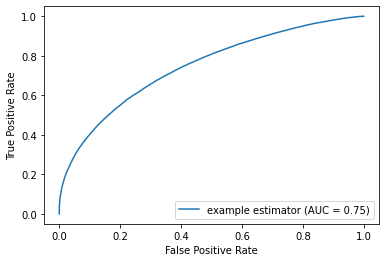

Overall AUC : 0.7452764269783646
Team: B 
5
/content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/models_saved/model_B_0.joblib


ic| val_y[:2]: 176360    0
               860935    1
               Name: team_B_scoring_within_10sec, dtype: category
               Categories (2, int64): [0, 1]
ic| predictions[:2]: array([0.10183844, 0.08977261])


predictions:[0.10183844 0.08977261 0.12990339 ... 0.05489123 0.04698769 0.03647266]
Fold 1 		 AUC: 0.7416709105280525


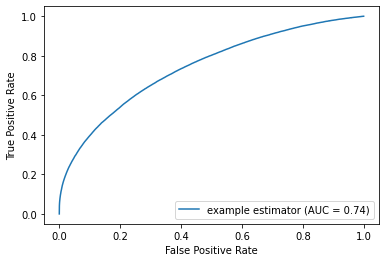

/content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/models_saved/model_B_1.joblib


ic| val_y[:2]: 440953     0
               1948527    0
               Name: team_B_scoring_within_10sec, dtype: category
               Categories (2, int64): [0, 1]
ic| predictions[:2]: array([0.06573545, 0.06477843])


predictions:[0.06573545 0.06477843 0.02528763 ... 0.02913354 0.03856366 0.03399575]
Fold 2 		 AUC: 0.7415832386773491


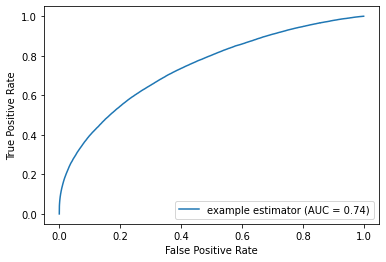

/content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/models_saved/model_B_2.joblib


ic| val_y[:2]: 282629     0
               1765627    0
               Name: team_B_scoring_within_10sec, dtype: category
               Categories (2, int64): [0, 1]
ic| predictions[:2]: array([0.34225058, 0.07817209])


predictions:[0.34225058 0.07817209 0.03076064 ... 0.05825464 0.06868035 0.061719  ]
Fold 3 		 AUC: 0.7415784564040805


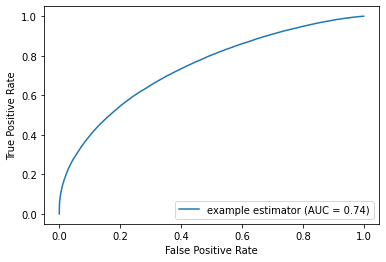

/content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/models_saved/model_B_3.joblib


ic| val_y[:2]: 1111514    0
               770636     0
               Name: team_B_scoring_within_10sec, dtype: category
               Categories (2, int64): [0, 1]
ic| predictions[:2]: array([0.05693153, 0.46886963])


predictions:[0.05693153 0.46886963 0.03067655 ... 0.0390883  0.10862359 0.26394247]
Fold 4 		 AUC: 0.7425824998213586


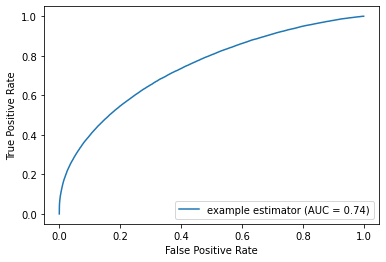

/content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/models_saved/model_B_4.joblib


ic| val_y[:2]: 1274297    0
               1177881    0
               Name: team_B_scoring_within_10sec, dtype: category
               Categories (2, int64): [0, 1]
ic| predictions[:2]: array([0.02768845, 0.03829524])


predictions:[0.02768845 0.03829524 0.01563883 ... 0.01626484 0.03470525 0.01651679]
Fold 5 		 AUC: 0.7433230243562396


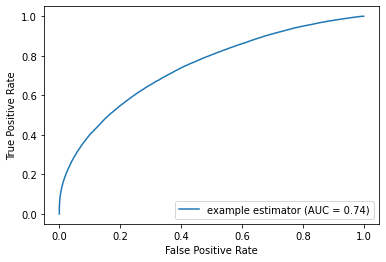

Overall AUC : 0.742147625957416
Overall AUC for Team A:  0.7452764269783646
Overall AUC for Team B:  0.742147625957416


In [ ]:
import pprint
from joblib import dump, load
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt 

scores = {'A': [], 'B': [] }
test_predictions = {'A': [], 'B': [] }




def run_model(X,y,test,key): 
  scores = []
  test_predictions = []
  cv = KFold(n_splits=N_SPLITS, random_state=my_seed, shuffle=True)
  print(N_SPLITS)
  for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    train_X, val_X = X.iloc[train_idx], X.iloc[test_idx]
    train_y, val_y = y.iloc[train_idx], y.iloc[test_idx]
    path= "/content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/models_saved"
    model_filepath = os.path.join(path,"model_" +str(key) + "_" + str(fold)+".joblib")
    print(model_filepath)
    # model = xgb.XGBClassifier()
    model = LGBMClassifier()
  
    model.set_params(**param)

    model.fit(train_X,train_y)

    dump(model,model_filepath)

    predictions = model.predict_proba(val_X)[:, 1]
    # predictions = model.predict_proba(val_X)
    print(f"predictions:{predictions}")

    #compute roc auc score
    ic(val_y[:2])
    ic(predictions[:2])
    score = roc_auc_score(val_y, predictions)
    scores.append(score)
    print(f"Fold {fold + 1} \t\t AUC: {score}")

    #display roc auc curve
    fpr, tpr, thresholds = metrics.roc_curve(val_y, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
    display.plot()
    plt.show()

    
    #test predictions with this model 
    test_predictions.append(model.predict_proba(test)[:,1])

    del model 
    gc.collect()
    
  print(f"Overall AUC :", np.mean(scores))
  return (np.mean(test_predictions, axis=0), np.mean(scores))

## use a sample of data again : 

for key in test_predictions:
  print(f"Team: {key} ")
  prediction,score = run_model(X_train,y_train[key],test,key)
  test_predictions[key].append(prediction)
  scores[key].append(score)

print('Overall AUC for Team A: ', np.mean(scores['A']))
print('Overall AUC for Team B: ', np.mean(scores['B']))
  

--> tchéquer les doubles 1 ! 

In [ ]:
test_predictions

{'A': [array([0.04130145, 0.02695551, 0.02335426, ..., 0.12081627, 0.01774503,
         0.04953407])],
 'B': [array([0.04457399, 0.14584364, 0.11367145, ..., 0.0442078 , 0.24416118,
         0.03663811])]}

In [ ]:
test_predictions
test_predictions['B']=test_predictions['B'][0]
test_predictions['A']=test_predictions['A'][0]

In [ ]:
test_predictions['team_A_scoring_within_10sec'].rename(['team_A_2_scoring_within_10sec'],axis=0, inplace=True)

AttributeError: ignored

In [ ]:
test_predictions['team_A_scoring_within_10sec']= test_predictions['A']
test_predictions['team_B_scoring_within_10sec']= test_predictions['B']
    

In [ ]:
test_predictions_deep_copy  = test_predictions.copy()

In [ ]:
del test_predictions['A']
del test_predictions['B']

In [ ]:
len(test_predictions['team_A_scoring_within_10sec'])
test_predictions['id'] = [i for i in range(len(test_predictions['team_A_scoring_within_10sec']))]

In [ ]:
test_predictions


KeyError: ignored

In [ ]:
import json

r = {'is_claimed': 'True', 'rating': 3.5}
r = json.dumps(r)

loaded_r = json.loads(r)
print(type(loaded_r))
loaded_r['rating'] #Output 3.5
type(r) #Output str
# type(loaded_r) #Output dict

<class 'dict'>


str

In [ ]:
submission=pd.DataFrame.from_dict(test_predictions)

In [ ]:
submission


,team_A_scoring_within_10sec,team_B_scoring_within_10sec,id
0,0.041301,0.044574,0
1,0.026956,0.145844,1
2,0.023354,0.113671,2
3,0.054197,0.040274,3
4,0.026724,0.059428,4
...,...,...,...
701138,0.364620,0.059176,701138
701139,0.020289,0.099189,701139
701140,0.120816,0.044208,701140
701141,0.017745,0.244161,701141


In [ ]:
submission_json = submission.to_json(orient ='values')

In [ ]:
# submission_json
submission.to_dict(orient='records')

[{'team_A_scoring_within_10sec': 0.041301453820530055,
  'team_B_scoring_within_10sec': 0.04457399229342961,
  'id': 0},
 {'team_A_scoring_within_10sec': 0.026955513743407277,
  'team_B_scoring_within_10sec': 0.14584363926476024,
  'id': 1},
 {'team_A_scoring_within_10sec': 0.02335425892486968,
  'team_B_scoring_within_10sec': 0.11367144586123142,
  'id': 2},
 {'team_A_scoring_within_10sec': 0.05419693516180535,
  'team_B_scoring_within_10sec': 0.04027449827626199,
  'id': 3},
 {'team_A_scoring_within_10sec': 0.026723762149333235,
  'team_B_scoring_within_10sec': 0.059428173284886796,
  'id': 4},
 {'team_A_scoring_within_10sec': 0.05797312097155592,
  'team_B_scoring_within_10sec': 0.03388305964287007,
  'id': 5},
 {'team_A_scoring_within_10sec': 0.08811680364692548,
  'team_B_scoring_within_10sec': 0.021935943364211053,
  'id': 6},
 {'team_A_scoring_within_10sec': 0.02922484225604267,
  'team_B_scoring_within_10sec': 0.049791840028465824,
  'id': 7},
 {'team_A_scoring_within_10sec': 0

In [ ]:
submission=pd.DataFrame.from_dict(test_predictions)
submission.rename(columns = {'B':'team_B_scoring_within_10sec','A':'team_A_scoring_within_10sec'}, inplace = True)
submission.to_csv('submission2.csv')

# Online Learning ?

# Deep Lerning for tabular data

**Work taken from this article: https://arxiv.org/pdf/2106.11959.pdf**

Due to the tremendous success of deep learning on such data domains as images, audio and texts
(Goodfellow et al., 2016), there has been a lot of research interest to extend this success to problems
with data stored in tabular format.

**Deep learning for tabular data ? **

During several recent years, a large number of deep learning models for tabular data have been
developed (Arik and Pfister, 2020; Badirli et al., 2020; Hazimeh et al., 2020; Huang et al., 2020a;
Klambauer et al., 2017; Popov et al., 2020; Song et al., 2019; Wang et al., 2017). 

We will focus on three models: 
- dummy 
- ResNet
- AttentionBased ? 



## Dummy

In [ ]:
import torch
from torch.functional import norm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from pathlib import Path
from torch import optim
import time
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from icecream import ic
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import datetime
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




In [ ]:
train_X_tensor=torch.tensor(X_train.values)
train_X_tensor.shape
train_y_A_tensor=torch.tensor(y_train['A'].values)
train_y_B_tensor=torch.tensor(y_train['B'].values)

In [ ]:
#### build dataset
from torch.utils.data import Dataset, DataLoader

class RocketDataset(Dataset):
  """
  This is a custom dataset class. It can get more complex than this, but simplified so you can understand what's happening here without
  getting bogged down by the preprocessing
  """
  def __init__(self, X, Y):
    self.X = X
    print(X.shape)
    self.Y = Y
    print(Y.shape)
    if len(self.X) != len(self.Y):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
      _x = self.X[index]
      _y = self.Y[index]
  
      return _x, _y



loader_A = DataLoader(RocketDataset(train_X_tensor, train_y_A_tensor), batch_size=32, shuffle=True)
loader_B= DataLoader(RocketDataset(train_X_tensor, train_y_B_tensor), batch_size=32, shuffle=True)
loader_train = {'A':loader_A,'B':loader_B}

for i in range(0, 5):
  # next x and next y
  x, y = next(iter(loader_A))
  print(x)
  print(y)

In [ ]:
ic(train_y["A"].shape)
ic(train_y['B'].shape)
ic(train_X.shape)
ic(test.shape)

In [ ]:
BATCH_SIZE=32
class training_global(nn.Module): 
    def __init__(self,criterion,device,opt,weight_decay,regularization=None,ckpt_save_path=None):
        super().__init__()
        self.criterion = criterion
        self.device = device
        self.regularization = regularization
        self.optimizer = opt
        self.state={}
        self.ckpt_save_path= ckpt_save_path
        self.weight_decay = weight_decay
    
    def __train_epoch(self,traindata,epoch):
        epoch_train_loss = 0
        epoch_train_acc  = 0 
        epoch_test_loss  = 0
        epoch_test_acc   = 0 
        for idx, data in enumerate(traindata):
            
            self.opt.zero_grad()
            input,label = data
            
            input = input.reshape(-1,self.input_size)
            b_size,n_features = input.shape
            if b_size==BATCH_SIZE:
                output = self(input,'Train',epoch) # self c'est le modèle
  
                # output = output.type(torch.LongTensor)
                label = label.type(torch.LongTensor)

                loss = self.criterion(output,label)

                if self.regularization == 'L1':
                    l1_lambda = 0.007253
                    l1_penalty = sum(p.abs().sum() for p in self.parameters())
                    loss = loss + l1_lambda * l1_penalty
                if self.regularization =="L2":
                    l2_lambda = 0.07253
                    l2_penalty = sum(p.pow(2.0).sum() for p in self.parameters())
                    loss = loss + l2_lambda*l2_penalty

                n_correct = (torch.argmax(output,dim=1)==label).sum().item()
                total     = label.size(0)
            
                epoch_train_acc += n_correct/total
                loss.backward()
                self.opt.step()
                epoch_train_loss += loss.item()

        # with torch.no_grad():
        #     for idx,data in enumerate(testdata):
        #         input,label = data
        #         input = input.reshape(-1,self.input_size)
        #         b_size,n_features = input.shape
        #         if b_size==BATCH_SIZE:
        #             output = self(input,'Test',epoch) # self c'est le modèle
        #             loss = self.criterion(output,label)
        #             n_correct = (torch.argmax(output,dim=1)==label).sum().item()
        #             total     = label.size(0)
        #             epoch_test_acc += n_correct/total
        #             epoch_test_loss += loss.item()
        


        return epoch_train_loss/len(traindata),epoch_train_acc/len(traindata)

    def __validate(self, dataloader,epoch):
        epoch_loss = 0
        epoch_acc  = 0
        for idx, data in enumerate(dataloader):
            self.opt.zero_grad()
            input,label = data
            
            input = input.reshape(-1,self.input_size)
            b_size,n_features = input.shape
            if b_size==BATCH_SIZE:
                output = self(input,'val',epoch) # self c'est le modèle
                loss = self.criterion(output,label)
                n_correct = (torch.argmax(output,dim=1)==label).sum().item()
                total     = label.size(0)
                epoch_acc += n_correct/total
                epoch_loss += loss.item()

            
        return epoch_loss/len(dataloader), epoch_acc/len(dataloader)


    def fit(self, traindata,testdata=None,validation_data=None,batch_size=300, start_epoch=0, n_epochs=1000, lr=0.001, verbose=10,ckpt=None):
        ic(lr)
        
        parameters = self.parameters()
        if self.optimizer=="SGD":
            self.opt = optim.SGD(parameters,lr=lr,momentum=0.9)
        if self.optimizer=='Adam':
            self.opt = torch.optim.Adam(parameters, lr=lr, weight_decay=self.weight_decay, amsgrad=False)
        start_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        
      

        if ckpt:
            state = torch.load(ckpt)
            start_epoch = state['epoch']
            self.load_state_dict(state['state_dict'])
            for g in self.opt.param_groups:
                g['lr'] = state['lr']
            
        for epoch in range(start_epoch,n_epochs):
            epoch_train_loss,epoch_train_acc = self.__train_epoch(traindata,epoch)
            print(f'\n Epoch {epoch+1} \n',
                        f'Train Loss= {epoch_train_loss:.4f}\n',f'Train Acc={epoch_train_acc:.4f}\n')
            
            

            # if epoch % 10 ==0 : 
            #     self.__weights_histo(epoch) #using weight histograms to have the weights of each linear layer. 
            # if validation_data is not None:
            #     with torch.no_grad():
            #         val_loss, val_acc = self.__validate(validation_data,epoch)
            #     print('Epoch {:2d} loss_val: {:1.4f}  val_acc: {:1.4f} '.format(epoch+1, val_loss, val_acc))
  
            if self.ckpt_save_path:
                self.state['lr'] = lr
                self.state['epoch'] = epoch
                self.state['state_dict'] = self.state_dict()
                if not os.path.exists(self.ckpt_save_path):
                    os.mkdir(self.ckpt_save_path)
                torch.save(self.state, os.path.join(self.ckpt_save_path, f'ckpt_{start_time}_epoch{epoch}.ckpt'))

   

In [ ]:


class DummyNet(training_global):
    def __init__(self,input_size,hidden_dim,output_size,criterion,device,opt,dropout, regularization=None,ckpt_save_path='//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/tabular-playground-series-oct-2022/runs',weight_decay=0):
        super(DummyNet,self).__init__(regularization = regularization,criterion =criterion,device = device,opt =  opt,ckpt_save_path= ckpt_save_path,weight_decay=weight_decay)
        self.input_size = input_size
        self.output_size = output_size
        self.linear1 = nn.Linear(input_size,hidden_dim)
        self.linear2 = nn.Linear(hidden_dim,hidden_dim)
        self.linear3 = nn.Linear(hidden_dim,output_size)
        self.activation = nn.ReLU()
        self.grads={}
        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)
        

    def forward(self,x,mode,epoch):
        "model changed to add dropout, regularisation and batchnorm"
        x1 = self.linear1(x)
        x1 = self.dropout1(x1)
        x2 = self.linear2(x1)
        x2 = self.dropout2(x2)
        out   = self.activation(self.linear3(x2))
        return out 
            



In [ ]:
criterion = torch.nn.CrossEntropyLoss()
regularization = "L1"
net = DummyNet(input_size=X_train.shape[1],hidden_dim=100,output_size=2,device = device,criterion=criterion,regularization = None,dropout=0.3, opt='Adam',weight_decay = 0.009348818325128058)


      

In [ ]:
test_predictions = {'A': [], 'B': [] }

for key in test_predictions:

  net.fit(loader_train[key])

# ResNet

In [ ]:


class resblock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

class ResNet(training_global):
  def __init__(self,
    in_channels,
    hidden_dim,
    out_size,
    criterion,
    device,
    opt,
    dropout, 
    regularization=None,
    ckpt_save_path='//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/tabular-playground-series-oct-2022/runs',
    weight_decay=0):
    
    super(ResNet,self).__init__(regularization = regularization,criterion =criterion,device = device,opt =  opt,ckpt_save_path= ckpt_save_path,weight_decay=weight_decay)
  
    self.layer0 = nn.Sequential(
      nn.Conv2D(in_channels, hidden_dim, kernel_size=7, stride=2, padding=3),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(hidden_dim),
      nn.ReLU()
        )
    self.layer1 = nn.Sequential(
        resblock(hidden_dim,hidden_dim , downsample=False),
        resblock(hidden_dim, hidden_dim, downsample=False)
    )

    self.layer2 = nn.Sequential(
        resblock(hidden_dim, hidden_dim*2, downsample=True),
        resblock(hidden_dim*2,hidden_dim*2, downsample=False)
    )

    self.layer3 = nn.Sequential(
        resblock(hidden_dim*2, hidden_dim*3, downsample=True),
        resblock(256, 256, downsample=False)
    )


    self.layer4 = nn.Sequential(
        resblock(hidden_dim*4, hidden_dim*8, downsample=True),
        resblock(hidden_dim*8, hidden_dim*8, downsample=False)
    )


    self.gap = torch.nn.AdaptiveAvgPool2d(1)
    self.fc = torch.nn.Linear(hidden_dim*8, out_size)


        

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input)
        out = self.fc(input)

        return out
            



In [ ]:
criterion = torch.nn.CrossEntropyLoss()
regularization = "L1"
net = DummyNet(input_size=X_train.shape[1],hidden_dim=100,output_size=2,device = device,criterion=criterion,regularization = None,dropout=0.3, opt='Adam',weight_decay = 0.009348818325128058)



In [ ]:
test_predictions = {'A': [], 'B': [] }

for key in test_predictions:

  net.fit(loader_train[key])

# transformer for Tabular data and Time series 

In [ ]:
# reading test dataset
dtypes_df = pd.read_csv('//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/train_dtypes.csv')
dtypes = {k: v for (k, v) in zip(dtypes_df.column, dtypes_df.dtype)}
train0_df = pd.read_csv('//content/drive/MyDrive/Colab/HEC_MAJEUR/AI_ADVANCED/TPS_Challenge/tabular-playground-series-oct-2022/train_0.csv', dtype=dtypes)

In [ ]:
train0_df

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,1,1002,-33.313030,-0.0000,0.000000,1.854800,-0.000000,0.000000,0.000000,41.804798,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3,B,0,0
1,1,1002,-33.206146,-0.0000,0.000000,1.854800,-0.000000,0.000000,0.000000,42.261600,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3,B,0,0
2,1,1002,-33.098114,-0.0000,0.000000,1.854800,-0.000000,0.000000,0.000000,43.227001,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3,B,0,0
3,1,1002,-32.993191,-0.0000,0.000000,1.854800,-0.000000,0.000000,0.000000,43.898399,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3,B,0,0
4,1,1002,-32.887756,-0.0000,0.000000,1.854800,-0.000000,0.000000,0.000000,44.960602,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3,B,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2149376,737,737005,-0.473386,11.6650,25.500801,15.000999,-11.037601,48.485401,30.185400,36.176399,...,0.0,-6.917969,-2.748047,-2.417969,-9.046875,-4.574219,-1,NaN,0,0
2149377,737,737005,-0.363688,10.3796,31.146999,18.421200,-10.998400,48.311802,28.563200,36.646599,...,0.0,-6.808594,-2.638672,-2.310547,-8.937500,-4.464844,-1,NaN,0,0
2149378,737,737005,-0.254574,9.1902,36.371002,21.428001,-10.962000,48.150600,27.061800,37.182400,...,0.0,-6.699219,-2.531250,-2.201172,-8.828125,-4.359375,-1,NaN,0,0
2149379,737,737005,-0.145479,8.1868,40.778202,23.845400,-10.931200,48.016201,25.795401,37.687801,...,0.0,-6.589844,-2.421875,-2.091797,-8.718750,-4.250000,-1,NaN,0,0


In [ ]:
import pprint
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt 

scores = {'A': [], 'B': [] }
test_predictions = {'A': [], 'B': [] }




def run_model(X,y,test,key): 
  scores = []
  test_predictions = []
  cv = KFold(n_splits=N_SPLITS, random_state=my_seed, shuffle=True)
  print(N_SPLITS)
  for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    train_X, val_X = X.iloc[train_idx], X.iloc[test_idx]
    train_y, val_y = y.iloc[train_idx], y.iloc[test_idx]

    # model = xgb.XGBClassifier()
    model = LGBMClassifier()
  
    model.set_params(**param)

    model.fit(train_X,train_y)

    predictions = model.predict_proba(val_X)[:, 1]
    # predictions = model.predict_proba(val_X)
    print(f"predictions:{predictions}")

    #compute roc auc score
    ic(val_y[:2])
    ic(predictions[:2])
    score = roc_auc_score(val_y, predictions)
    scores.append(score)
    print(f"Fold {fold + 1} \t\t AUC: {score}")

    #display roc auc curve
    fpr, tpr, thresholds = metrics.roc_curve(val_y, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
    display.plot()
    plt.show()

    
    #test predictions with this model 
    test_predictions.append(model.predict_proba(test)[:,1])

    del model 
    gc.collect()
    
  print(f"Overall AUC :", np.mean(scores))
  return (np.mean(test_predictions, axis=0), np.mean(scores))

## use a sample of data again : 

for key in test_predictions:
  print(f"Team: {key} ")
  prediction,score = run_model(X_train,y_train[key],test,key)
  test_predictions[key].append(prediction)
  scores[key].append(score)

print('Overall AUC for Team A: ', np.mean(scores['A']))
print('Overall AUC for Team B: ', np.mean(scores['B']))
  